# **Twitter Classification** (Sentiment Analysis)

___
By Abdullah

## Libraries

In [1]:
!pip install tensorflow

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import optimizers

In [4]:
## ====> Libraries for Preprocessing
import re
import string

In [5]:
from sklearn.metrics import accuracy_score, classification_report

## Reading Dataset

In [8]:
df_train = pd.read_csv(r"/content/drive/MyDrive/NLP/Projects/Twitter Sentiment Analysis/twitter_training.csv")
df_val = pd.read_csv(r"/content/drive/MyDrive/NLP/Projects/Twitter Sentiment Analysis/twitter_validation.csv")

In [9]:
df_train.columns =['ID','entity','sentiment','tweet_content']
df_val.columns =['ID','entity','sentiment','tweet_content']

In [10]:
df_train.head()

,ID,entity,sentiment,tweet_content
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [11]:
df_train['sentiment'].value_counts()

,count
sentiment,
Negative,22542
Positive,20831
Neutral,18318
Irrelevant,12990


In [12]:
df_train.dropna(inplace=True)
df_train.drop_duplicates(inplace=True)

In [13]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71655 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ID             71655 non-null  int64 
 1   entity         71655 non-null  object
 2   sentiment      71655 non-null  object
 3   tweet_content  71655 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.7+ MB


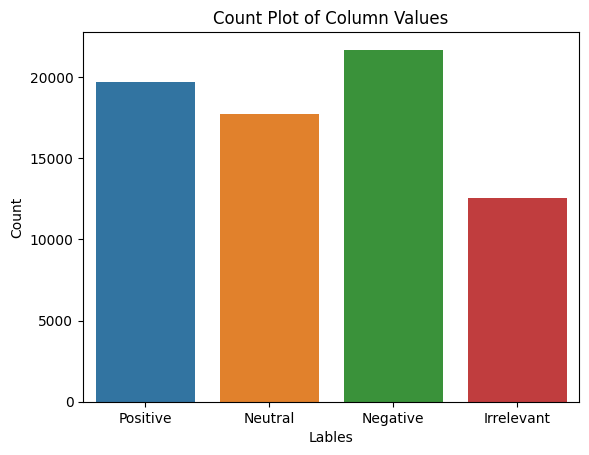

In [14]:
sns.countplot(x='sentiment', data=df_train, hue='sentiment')
plt.xlabel('Lables')
plt.ylabel('Count')
plt.title('Count Plot of Column Values')
plt.show()

## Text Preprocessing (LSTM)

In [15]:
from sklearn.preprocessing import LabelEncoder
l = LabelEncoder()
y_train = l.fit_transform(df_train['sentiment'])
y_val = l.transform(df_val['sentiment'])

In [16]:
print("Categories and their labels:")
for label, category in enumerate(l.classes_):
    print(f"Label {label}: {category}")

Categories and their labels:
Label 0: Irrelevant
Label 1: Negative
Label 2: Neutral
Label 3: Positive


In [17]:
def clean_txt(text):
  text = text.lower()
  text = re.sub(r'http\S+|www\S+|https\S+', '', text)
  text = re.sub(r'\@\w+|\#', '', text)
  text = re.sub(r'[^a-zA-Z\s]', '', text)
  text = re.sub(r'\d+', '', text)
  return text

df_train['pross_tweet_content'] = df_train['tweet_content'].apply(clean_txt)
df_val['pross_tweet_content'] = df_val['tweet_content'].apply(clean_txt)

In [18]:
trn_text_dl = df_train['pross_tweet_content']
tst_text_dl = df_val['pross_tweet_content']

## Toknization & Embedding (Glove)

In [19]:
MAX_WORDS =5000
MAX_LEN = 100
tokenizer_dl = Tokenizer(num_words=MAX_WORDS, lower = True, oov_token='<OOV>')
tokenizer_dl.fit_on_texts(trn_text_dl)

X_train_dl = tokenizer_dl.texts_to_sequences(trn_text_dl)
X_test_dl = tokenizer_dl.texts_to_sequences(tst_text_dl)

X_train_dl_padded = pad_sequences(X_train_dl, maxlen=100, padding='post', truncating='post' )
X_test_dl_padded = pad_sequences(X_test_dl, maxlen=100, padding='post',  truncating='post')

In [ ]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip -P /content/drive/MyDrive/NLP

--2025-08-11 11:59:39--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-08-11 11:59:39--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-08-11 11:59:39--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘/content/drive/MyDr

In [ ]:
# import zipfile

# zip_path = '/content/drive/MyDrive/NLP/glove.6B.zip'
# extract_path = '/content/drive/MyDrive/NLP/glove.6B'

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

# print("Path", extract_path)

Path /content/drive/MyDrive/NLP/glove.6B


In [20]:
embedding_index = {}
with open('/content/drive/MyDrive/NLP/glove.6B/glove.6B.100d.txt', 'r', encoding='utf-8') as f:
  for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    embedding_index[word] = vector

EMBEDDING_DIM = 100
word_index = tokenizer_dl.word_index
embedding_matrix = np.zeros((MAX_WORDS, EMBEDDING_DIM))

for word, i in word_index.items():
  if i < MAX_WORDS:
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

## Bidirectional LSTM Model

In [23]:
vocab_size = len(word_index)+1
embedding_dim = 100

model = models.Sequential()
model.add(
    layers.Embedding(
        input_dim = MAX_WORDS,
        output_dim = embedding_dim,
        weights = [embedding_matrix],
        input_length = MAX_LEN,
        trainable = False
    )
)
model.add(layers.Bidirectional(layers.LSTM(128)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(4, activation='softmax'))
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
    loss=losses.sparse_categorical_crossentropy,
    metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │       500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 500,000 (1.91 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 500,000 (1.91 MB)

In [24]:
history = model.fit(
    X_train_dl_padded,
    y_train,
    batch_size=128,
    epochs=20,
    validation_data=(X_test_dl_padded, y_val),
    )

Epoch 1/20
560/560 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.4405 - loss: 1.2416 - val_accuracy: 0.5576 - val_loss: 1.0347
Epoch 2/20
560/560 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.5516 - loss: 1.0656 - val_accuracy: 0.6036 - val_loss: 0.9177
Epoch 3/20
560/560 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.5927 - loss: 0.9774 - val_accuracy: 0.6627 - val_loss: 0.7990
Epoch 4/20
560/560 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.6300 - loss: 0.8929 - val_accuracy: 0.7177 - val_loss: 0.7142
Epoch 5/20
560/560 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.6765 - loss: 0.7994 - val_accuracy: 0.7748 - val_loss: 0.5859
Epoch 6/20
560/560 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.7145 - loss: 0.7134 - val_accuracy: 0.8158 - val_loss: 0.5019
Epoch 7/20
560/560 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.7510 - loss: 0.6271 - val_accuracy: 0.8559 - val_loss: 0.4069
Epoch 8/20
560/560 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.7834 - loss: 0.5549 - 

In [29]:
y_pred = model.predict(X_test_dl_padded)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


In [31]:
np.argmax(y_pred[0])

np.int64(2)

In [25]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

print(f"Final Training Accuracy: {train_accuracy[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accuracy[-1]:.4f}")
print(f"Final Training Loss: {train_loss[-1]:.4f}")
print(f"Final Validation Loss: {val_loss[-1]:.4f}")

Final Training Accuracy: 0.9024
Final Validation Accuracy: 0.9409
Final Training Loss: 0.2509
Final Validation Loss: 0.2243


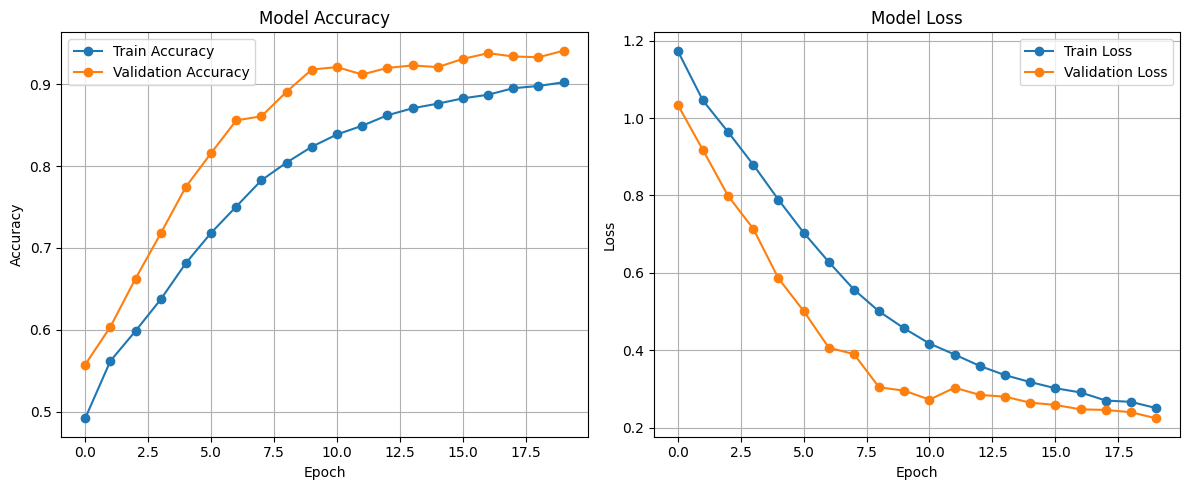

In [26]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Accuracy', marker='o')
plt.plot(val_acc, label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss', marker='o')
plt.plot(val_loss, label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Saving Model

In [27]:
model.save(r'/content/drive/MyDrive/NLP/Projects/Twitter Sentiment Analysis/twitter_lstm_sentiment_model.h5')

In [33]:
with open(r'/content/drive/MyDrive/NLP/Projects/Twitter Sentiment Analysis/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer_dl, f)

## Streamlit app

In [36]:
%%writefile twitter_app.p

import streamlit as st
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load model and tokenizer
@st.cache_resource
def load_model_and_tokenizer():
    model = tf.keras.models.load_model(r'/content/drive/MyDrive/NLP/Projects/Twitter Sentiment Analysis/twitter_lstm_sentiment_model.h5')
    with open(r'/content/drive/MyDrive/NLP/Projects/Twitter Sentiment Analysis/tokenizer.pkl', 'rb') as f:
        tokenizer = pickle.load(f)
    return model, tokenizer

model, tokenizer = load_model_and_tokenizer()

# Text cleaning function (matching notebook preprocessing)
# stop_words = set(stopwords.words('english'))
# stemmer = PorterStemmer()

def clean_txt(text):
  text = text.lower()
  text = re.sub(r'http\S+|www\S+|https\S+', '', text)
  text = re.sub(r'\@\w+|\#', '', text)
  text = re.sub(r'[^a-zA-Z\s]', '', text)
  text = re.sub(r'\d+', '', text)
  return text

# Prediction function
def predict_sentiment(tweet, max_len=100):
    cleaned = clean_txt(tweet)
    seq = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(seq, maxlen=max_len)
    pred = model.predict(padded, verbose=0)[0][0]
    p = np.argmax(pred)
    if p == 0 :
      sentiment = 'Irrelevant'
    elif p ==1:
      sentiment = 'Negative'
    elif p ==2:
      sentiment = 'Neutral'
    elif p ==3:
      sentiment = 'Positive'

    return sentiment, pred
#     Categories and their labels:
# Label 0: Irrelevant
# Label 1: Negative
# Label 2: Neutral
# Label 3: Positive

# Streamlit app layout
st.title("Twitter Sentiment Analysis with LSTM")
st.write("Enter a tweet to predict its sentiment (positive, negative, Netural or Irrelevant).")

# User input
user_input = st.text_area("Tweet", "Type your tweet here...", height=100)

# Predict button
if st.button("Predict Sentiment"):
    if user_input:
        sentiment, score = predict_sentiment(user_input)
        st.success(f"**Sentiment**: {sentiment}")
        # st.write(f"**Confidence Score**: {score:.2%}")

        # Bar chart for sentiment scores
        fig, ax = plt.subplots()
        scores = [1 - score, score]
        labels = ['Irrelevant', 'Negative', 'Neutral', 'Positive']
        sns.barplot(x=scores, y=labels, palette=['#FF6B6B', '#4ECDC4'])
        ax.set_xlabel('Probability')
        ax.set_title('Sentiment Prediction Confidence')
        st.pyplot(fig)
    else:
        st.error("Please enter a tweet.")


Writing twitter_app.p
